In [1]:
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [56]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

        
    def copy(self):
        new_TicTacToe = TicTacToe(n_rows=self.n_rows, n_cols=self.n_cols, n_win=self.n_win)
        new_TicTacToe.board = self.board
        new_TicTacToe.gameOver = self.gameOver
        new_TicTacToe.boardHash = self.boardHash
        new_TicTacToe.curTurn = self.curTurn
        new_TicTacToe.emptySpaces = self.emptySpaces
        return new_TicTacToe
        
    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def getBoard(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [54]:
class RandomPlayer():
    def step(self, state, symb, actions):
        return random.choice(actions)
    def choose_a(self, state, symb, actions):
        index = [i for i in range(len(actions))]
        return np.random.choice(index)

In [5]:
def play_games(env, players, games=100):
    counter = {'X': 0,
               '0': 0,
               'draw': 0}
    for _ in range(games):
        env.reset()
        done = False
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            symb = 'X' if env.curTurn == 1 else '0'
            a = players[symb].step(s, symb, actions)
            observation, reward, done, info = env.step(a)
            if reward == -10:
                observation, reward, done, info = env.step(random.choice(actions))
        winner = 'X' if reward == 1 else ('0' if reward == -1 else 'draw')
        counter[winner] += 1
    return {k: v/games for k, v in counter.items()}


In [157]:
def draw(history, itter=1):
    games = [i*itter for i in range(len(history['X']))]
    plt.plot(games, history['X'], 'r-', label='win X')
    plt.plot(games, history['0'], 'g-', label='win 0')
    plt.plot(games, history['draw'], 'b-', label='draw')
    plt.legend()
    plt.show()

# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.


1.   Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2.   Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.


In [7]:
class QLearningTable():
    def __init__(self, bord=3, q_init=0.6, alpha=0.9, gamma=0.95):
        self.env = TicTacToe(n_rows=bord, n_cols=bord, n_win=bord)
        self.Q = {'X': {},
                  '0': {}}
        self.q_init = q_init
        self.alpha = alpha
        self.gamma = gamma
        self.games = []
        self.eval = {'X': [], '0': [],'draw': []}
        self.counter = {'X': 0, '0': 0, 'draw': 0}
        
    def run_episode(self, games=100):
        done = False
        self.env.reset()
        episode = {'X': [],
                   '0': []}
        while not done:
            s, actions = self.env.getHash(), self.env.getEmptySpaces()
            symb = 'X' if self.env.curTurn == 1 else '0'
            a = self.choose_a(symb, s, actions)
            episode[symb].append((s, a))
            observation, reward, done, info = self.env.step(actions[a])
        winner = 'X' if reward == 1 else ('0' if reward == -1 else 'draw')
        self.update_Q(episode, winner)
        self.counter[winner] += 1
        if sum([i for i in self.counter.values()]) == games:
            self.draw(self.counter, games)
            self.counter = {'X': 0, '0': 0, 'draw': 0}

    def choose_a(self, symb, s, actions):
        if self.Q[symb].get(s) is None:
            self.Q[symb][s] = np.array([self.q_init] * len(actions))
        index = np.where(self.Q[symb][s] == np.max(self.Q[symb][s]))[0]
        return np.random.choice(index)

    def update_Q(self, episode, winner):
        for symb, epis in episode.items():
            reward = 1 if symb == winner else 0.5 if winner == 'draw' else 0
            epis.reverse()
            s, a = epis[0]
            self.Q[symb][s][a] = reward
            max_a = max(self.Q[symb][s])
            for s, a in epis[1:]:
                self.Q[symb][s][a] = (1-self.alpha) * self.Q[symb][s][a] + self.alpha * self.gamma * max_a
                max_a = max(self.Q[symb][s])
    
    def step(self, s, symb, actions):
        if self.Q[symb].get(s) is None:
            self.Q[symb][s] = np.array([self.q_init] * len(actions))
        index = np.where(self.Q[symb][s] == np.max(self.Q[symb][s]))[0]
        return actions[np.random.choice(index)]
    
    def draw(self, counter, games):
        prev_games = 0 if len(self.games) == 0 else self.games[-1]
        self.games.append(prev_games + games)
        for k in self.eval.keys():
            self.eval[k].append(counter[k]/games)
        clear_output(wait=True)
        plt.plot(self.games, self.eval['X'], 'r-', label='win X')
        plt.plot(self.games, self.eval['0'], 'g-', label='win 0')
        plt.plot(self.games, self.eval['draw'], 'b-', label='draw')
        plt.legend()
        plt.show()

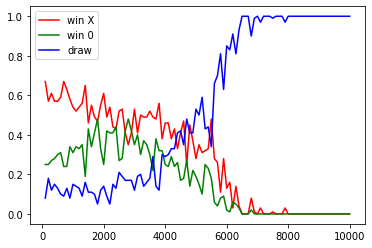

In [164]:
N_BOARD = 3
table_ttt= QLearningTable(bord=N_BOARD)
random_ttt= RandomPlayer()
env = TicTacToe(n_rows=N_BOARD, n_cols=N_BOARD, n_win=N_BOARD)
history_X = {'X': [], '0': [], 'draw': []}
history_0 = {'X': [], '0': [], 'draw': []}
for i in range(100):
    for j in range(100):
        print("\rCheck {}/{}.".format(i*100+j, 100*100), end="")
        table_ttt.run_episode()
    
    players = {'X': table_ttt,
               '0': random_ttt}
    result = play_games(env, players)
    history_X['X'].append(result['X'])
    history_X['0'].append(result['0'])
    history_X['draw'].append(result['draw'])
    
    players = {'X': random_ttt,
               '0': table_ttt}
    result = play_games(env, players)
    history_0['X'].append(result['X'])
    history_0['0'].append(result['0'])
    history_0['draw'].append(result['draw'])

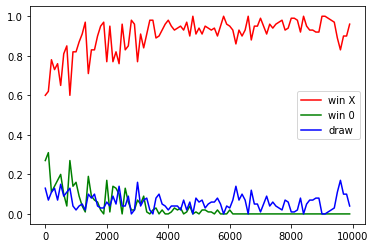

In [165]:
draw(history_X, 100)

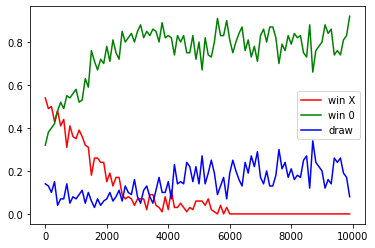

In [166]:
draw(history_0, 100)

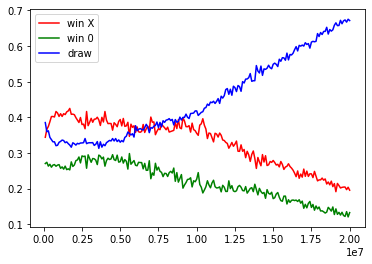

Check 100/100.

In [28]:
N_BOARD = 4
table_ttt= QLearningTable(bord=N_BOARD)
random_ttt= RandomPlayer()
env = TicTacToe(n_rows=N_BOARD, n_cols=N_BOARD, n_win=N_BOARD)
history_random = {'X': [], '0': [], 'draw': []}
for i in range(200):
    for j in range(100000):
        table_ttt.run_episode()
    
    players = {'X': table_ttt,
               '0': random_ttt}
    result = play_games(env, players)
    history_random['X'].append(result['X'])
    history_random['0'].append(result['0'])
    history_random['draw'].append(result['draw'])

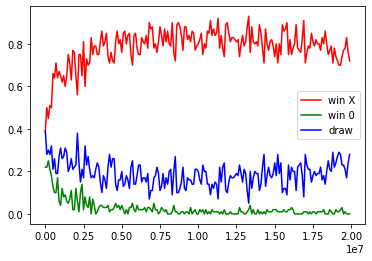

In [29]:
draw(history_random, 100000)


# Часть вторая: добавим нейронных сетей 
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).  

3.   Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

4.   Реализуйте Double DQN и/или Dueling DQN.

In [10]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [11]:
class Network(nn.Module):
    def __init__(self, bord=3):
        nn.Module.__init__(self)
        
        self.conv = nn.Conv2d(3, 128 * 2, (3, 3))
        self.l1 = nn.Linear(128 * 2, 128)
        self.l2 = nn.Linear(128, bord*bord)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        return self.l2(x)

In [154]:
class TicTacToeDQN():
    def __init__(self, Network, bord=3):
        self.env = TicTacToe(n_rows=bord, n_cols=bord, n_win=bord)
        self.bord = bord
        self.symbols = ['X', '0']
        self.model = {symb: Network for symb in self.symbols}
        self.memory = {symb: ReplayMemory(10000) for symb in self.symbols}
        self.optimizer = {symb: optim.Adam(self.model[symb].parameters(), 0.001) for symb in self.symbols}
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = {symb: 0 for symb in self.symbols}
        
        self.opponent = RandomPlayer()

    def select_greedy_action(self, state, symb):        
        return self.model[symb](state).data.max(1)[1].view(1, 1)

    def select_action(self, state, symb):
        sample = random.random()
        self.num_step[symb] += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step[symb] / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, symb)
        else:
            return torch.tensor([[random.randrange(2)]], dtype=torch.int64)
        
    def hash_to_tensor(self, state):
        symb = ['2', '0', '1']
        arr = [[[1 if j == i else 0 
                 for num, j in enumerate(state) if int(num/self.bord) == row] 
                for row in range(self.bord)]
               for i in symb]
        return torch.tensor([arr], dtype=torch.float32)
    
    def step(self, state, symb, actions=None):
        action = self.model[symb](self.hash_to_tensor(state)).data.max(1)[1].view(1, 1)
        action = action.numpy()[0][0]
        return [int(action/self.bord), action%self.bord]
        
    def run_episode(self, do_learning=True, greedy=False):
        done = False
        self.env.reset()
        update = 'X'
        while not done:
            s = self.hash_to_tensor(self.env.getHash())
            with torch.no_grad():
                if greedy:
                    a = self.select_greedy_action(s, update)
                else:
                    a = self.select_action(s, update)
            action = [int(a.numpy()[0][0] / self.bord), a.numpy()[0][0] % self.bord]
            (next_s, _, _), reward, done, _ = self.env.step(action)
            next_s = self.hash_to_tensor(next_s)
            if not done:
                action = self.opponent.step(self.env.getHash(), '0', self.env.getEmptySpaces())
                (next_s, _, _), reward, done, _ = self.env.step(action)
                next_s = self.hash_to_tensor(next_s)
            else:
                if update == '0' and abs(reward) == 1:
                    reward = -reward
            transition = (s, a, next_s, torch.tensor([reward], dtype=torch.float32))
            self.memory[update].store(transition)
            if do_learning:
                self.learn(update)  
            
        done = False
        self.env.reset()
        update = '0'
        action = self.opponent.step(self.env.getHash(), 'X', self.env.getEmptySpaces())
        (next_s, _, _), reward, done, _ = self.env.step(action)
        while not done:
            s = self.hash_to_tensor(self.env.getHash())
            with torch.no_grad():
                if greedy:
                    a = self.select_greedy_action(s, update)
                else:
                    a = self.select_action(s, update)
            action = [int(a.numpy()[0][0] / self.bord), a.numpy()[0][0] % self.bord]
            (next_s, _, _), reward, done, _ = self.env.step(action)
            next_s = self.hash_to_tensor(next_s)
            if not done:
                action = self.opponent.step(self.env.getHash(), 'X', self.env.getEmptySpaces())
                (next_s, _, _), reward, done, _ = self.env.step(action)
                next_s = self.hash_to_tensor(next_s)
            else:
                if update == '0' and abs(reward) == 1:
                    reward = -reward
            transition = (s, a, next_s, torch.tensor([reward], dtype=torch.float32))
            self.memory[update].store(transition)
            if do_learning:
                self.learn(update)  

    def learn(self, symb):
        if len(self.memory[symb]) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory[symb].sample(self.batch_size)
        
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model[symb](batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model[symb](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer[symb].zero_grad()
        loss.backward()
        self.optimizer[symb].step()

In [156]:
N_BOARD = 3
Network = Network(bord=N_BOARD) 
dqn_ttt= TicTacToeDQN(Network, bord=N_BOARD)
random_ttt= RandomPlayer()
env = TicTacToe(n_rows=N_BOARD, n_cols=N_BOARD, n_win=N_BOARD)
history_X = {'X': [], '0': [], 'draw': []}
history_0 = {'X': [], '0': [], 'draw': []}
for i in range(100):
    for j in range(100):
        print("\rCheck {}/{}.".format(i*100+j, 100*100), end="")
        dqn_ttt.run_episode()
    
    players = {'X': dqn_ttt,
               '0': random_ttt}
    result = play_games(env, players)
    history_X['X'].append(result['X'])
    history_X['0'].append(result['0'])
    history_X['draw'].append(result['draw'])
    
    players = {'X': random_ttt,
               '0': dqn_ttt}
    result = play_games(env, players)
    history_0['X'].append(result['X'])
    history_0['0'].append(result['0'])
    history_0['draw'].append(result['draw'])

Check 9999/10000.

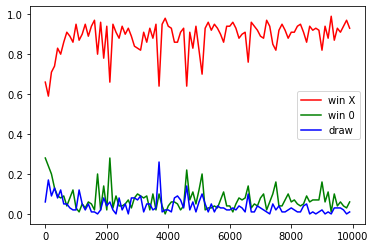

In [158]:
draw(history_X, 100)

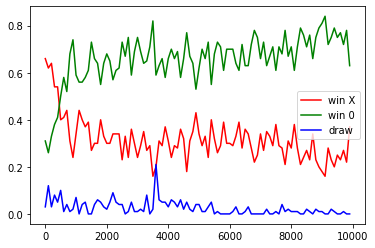

In [159]:
draw(history_0, 100)

In [160]:
class DuelingNetwork(nn.Module):
    def __init__(self, bord=3):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, 128 * 2, (3, 3))
        self.l1 = nn.Linear(128 * 2, 128)
        self.v = nn.Linear(128, 1)
        self.a = nn.Linear(128, bord*bord)
        

    def forward(self, x):
        x = F.relu(self.conv(x))
        x =  self.l1(x.view(-1, 128 * 2))
        v = self.v(x)
        a = self.a(x)
        return v + a - torch.mean(a)

In [161]:
N_BOARD = 3
Network = DuelingNetwork(bord=N_BOARD) 
dqn_ttt= TicTacToeDQN(Network, bord=N_BOARD)
random_ttt= RandomPlayer()
env = TicTacToe(n_rows=N_BOARD, n_cols=N_BOARD, n_win=N_BOARD)
history_X = {'X': [], '0': [], 'draw': []}
history_0 = {'X': [], '0': [], 'draw': []}
for i in range(100):
    for j in range(100):
        print("\rCheck {}/{}.".format(i*100+j, 100*100), end="")
        dqn_ttt.run_episode()
    
    players = {'X': dqn_ttt,
               '0': random_ttt}
    result = play_games(env, players)
    history_X['X'].append(result['X'])
    history_X['0'].append(result['0'])
    history_X['draw'].append(result['draw'])
    
    players = {'X': random_ttt,
               '0': dqn_ttt}
    result = play_games(env, players)
    history_0['X'].append(result['X'])
    history_0['0'].append(result['0'])
    history_0['draw'].append(result['draw'])

Check 9999/10000.

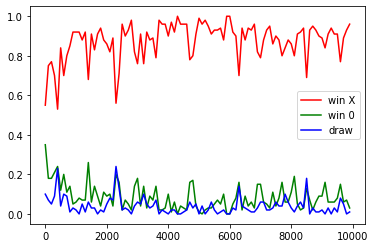

In [162]:
draw(history_X, 100)

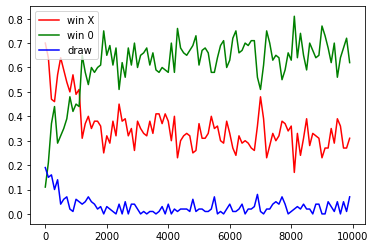

In [163]:
draw(history_0, 100)

# Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.


5.   Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6.   Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [146]:
class TicTacToeMCTS():
    def __init__(self, bord=3, q_init=0.6, alpha=0.9, gamma=0.95):
        self.env = TicTacToe(n_rows=bord, n_cols=bord, n_win=bord)
        self.player_rand = RandomPlayer()
        
        self.visit = {'X': {}, '0': {}}
        self.win = {'X': {}, '0': {}}
        
        self.q_init = q_init
        self.alpha = alpha
        self.gamma = gamma
        
    def run_episode(self, games=100):
        episode = {'X': [],
                   '0': []}
        
        update = 'X'
        done = False
        self.env.reset()
        while not done:
            s, actions = self.env.getHash(), self.env.getEmptySpaces()
            a = self.choose_a(update, s, actions, episode)
            episode[update].append((s, a))
            _, reward, done, info = self.env.step(actions[a])
            if not done:
                _, reward, done, info = self.env.step(self.player_rand.step(s, '0', self.env.getEmptySpaces()))
            
        done = False
        self.env.reset()
        update = '0'
        _, reward, done, info = self.env.step(self.player_rand.step(s, 'X', self.env.getEmptySpaces()))
        while not done:
            s, actions = self.env.getHash(), self.env.getEmptySpaces()
            a = self.choose_a(update, s, actions, episode)
            episode[update].append((s, a))
            _, reward, done, info = self.env.step(actions[a])
            if not done:
                _, reward, done, info = self.env.step(self.player_rand.step(s, 'X', self.env.getEmptySpaces()))
       
            
    def choose_a(self, symb, state, actions, episode):
        if self.visit[symb].get(state) is None:
            self.visit[symb][state] = np.zeros(len(actions))
            self.win[symb][state] = np.zeros(len(actions))
            
            for next_step in range(len(actions)):
                for _ in range(100):
                    env_copy = self.env.copy()
                    observation, reward, done, info = env_copy.step(actions[next_step])
                    while not done:
                        s, act = env_copy.getHash(), env_copy.getEmptySpaces()
                        symb_current = 'X' if env_copy.curTurn == 1 else '0'
                        a = self.player_rand.step(s, symb_current, act)
                        observation, reward, done, info = env_copy.step(a)
                    winner = 'X' if reward == 1 else ('0' if reward == -1 else 'draw')
                    self.visit[symb][state][next_step] += 1
                    self.win[symb][state][next_step] += 1 if symb == winner else (0.5 if symb == 'draw' else 0)
                
            for parents_s, pos in episode[symb]:
                self.visit[symb][parents_s][pos] += sum(self.visit[symb][state])
                self.win[symb][parents_s][pos] += sum(self.win[symb][state])
                
                
        roll = np.array([(i+1)/(j+1) + np.sqrt(2*np.log(len(actions)+1)/(j+1))
                         for i, j in zip(self.win[symb][state], self.visit[symb][state])])
        index = np.where(roll == np.max(roll))[0]
        return np.random.choice(index)

    def step(self, state, symb, actions):
        if self.visit[symb].get(state) is None:
            visit = np.zeros(len(actions))
            win = np.zeros(len(actions))
            
            for next_step in range(len(actions)):
                for _ in range(100):
                    env_copy = self.env.copy()
                    observation, reward, done, info = env_copy.step(actions[next_step])
                    while not done:
                        s, act = env_copy.getHash(), env_copy.getEmptySpaces()
                        symb_current = 'X' if env_copy.curTurn == 1 else '0'
                        a = self.player_rand.step(s, symb_current, act)
                        observation, reward, done, info = env_copy.step(a)
                    winner = 'X' if reward == 1 else ('0' if reward == -1 else 'draw')
                    visit += 1
                    win += 1 if symb == winner else (0.5 if symb == 'draw' else 0)
        else:
            visit = self.visit[symb][state]
            win = self.win[symb][state]
         
        roll = np.array([i/j  for i, j in zip(win, visit)])
        index = np.where(roll == np.max(roll))[0]
        return actions[np.random.choice(index)]

In [140]:
N_BOARD = 3
mcts_ttt= TicTacToeMCTS(bord=N_BOARD)
random_ttt= RandomPlayer()
env = TicTacToe(n_rows=N_BOARD, n_cols=N_BOARD, n_win=N_BOARD)
history_X = {'X': [], '0': [], 'draw': []}
history_0 = {'X': [], '0': [], 'draw': []}
for i in range(100):
    for j in range(100):
        print("\rCheck {}/{}.".format(i*100+j, 100*100), end="")
        mcts_ttt.run_episode()
    
    players = {'X': mcts_ttt,
               '0': random_ttt}
    result = play_games(env, players)
    history_X['X'].append(result['X'])
    history_X['0'].append(result['0'])
    history_X['draw'].append(result['draw'])
    
    players = {'X': random_ttt,
               '0': mcts_ttt}
    result = play_games(env, players)
    history_0['X'].append(result['X'])
    history_0['0'].append(result['0'])
    history_0['draw'].append(result['draw'])

Check 9999/10000.

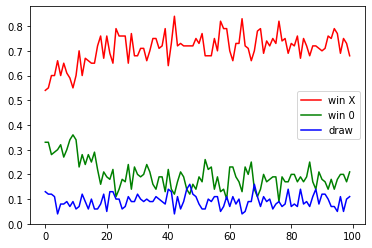

In [141]:
draw(history_X)

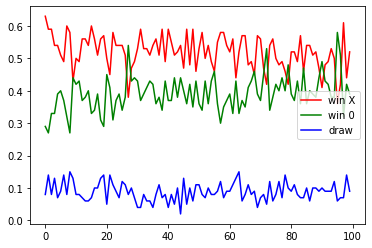

In [142]:
draw(history_0)

In [147]:
N_BOARD = 4
mcts_ttt= TicTacToeMCTS(bord=N_BOARD)
random_ttt= RandomPlayer()
env = TicTacToe(n_rows=N_BOARD, n_cols=N_BOARD, n_win=N_BOARD)
history_X = {'X': [], '0': [], 'draw': []}
history_0 = {'X': [], '0': [], 'draw': []}
for i in range(100):
    for j in range(1000):
        print("\rCheck {}/{}.".format(i*100+j, 100*100), end="")
        mcts_ttt.run_episode()
    
    players = {'X': mcts_ttt,
               '0': random_ttt}
    result = play_games(env, players)
    history_X['X'].append(result['X'])
    history_X['0'].append(result['0'])
    history_X['draw'].append(result['draw'])

Check 10899/10000.

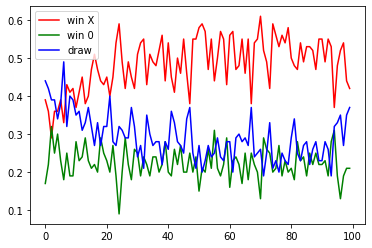

In [151]:
draw(history_X)